# API Module Project by Yoseph Zuskin, 2019-12-26

In [1]:
# Load the packages needed for this Notebook
import requests
import json
import urllib3
import certifi
import bs4
import time
import random
from math import ceil
from string import punctuation
from inflect import engine
from collections import defaultdict
from datetime import date, datetime
import matplotlib.pyplot as plt
import nltk.sentiment.util
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier

## Using the Yelp Fusion API to Obtain List of Toronto Businesses

In [2]:
# Load your Yelp Fusion API key from text file in same folder as this Notebook
with open('Yelp_API_Key.txt', 'r') as file:
    yelp_key = file.read()
    
# Alternatively, you may comment out the lines above and uncomment the line below to directly insert your API key
#yelp_key = ''

In [3]:
# Define the string to initiate the Yelp Fusion API requests
yelp_fusion_api_key = {'Authorization': 'Bearer %s' % yelp_key}

In [4]:
# Obtain the Yelp aliases of 1,000 businesses in Toronto by 20 iterations which collect 50 aliases in each,
# in order to conform with the limitations of the Yelp Fusion API search capability
toronto_businesses = list() # First create an empty list into which the JSON data will be added
endpoint = 'https://api.yelp.com/v3/businesses/search?location=toronto' # Declare the API endpoint
for i in range(0,1000,50): # Iterate over 0 to 950 to offset the search by that number each iteration
    # Submit a get request from the Yelp Fusion API to obtain 50 business aliases in each iteration
    r = requests.get(endpoint+'&limit=50&offset='+str(i), # Offset for the next 50 businesses
                     # Activate the API using the key which you uploaded via text file in an ealier cell
                     headers=yelp_fusion_api_key)
    # Append the resulting list of 50 business Yelp alises to the existing list of Toronto businesses
    toronto_businesses.extend(json.loads(r.content)['businesses'])

In [5]:
# Initiate a random seed instance of your choosing (randomly select your own seed if you choose to run this)
random.seed(454)
"""
The code below will randomly select 120 Toronto businesses from the list obtained from the cell above in order
to use their aliases to scrape the Yelp.ca website for full reviews. The webscraping code written in the cells
below should take approximately one and a half hours or so to completely loop over 2 Yelp pages for each of the
Toronto businesses and obtain as many reviews as possible from those two pages. If you would like to reduce the
time it will take the webscraping to complete, reduce the number of Toronto businesses which are randomly sampled
by changing the k parameter in the random.sample function called in the line below.
"""
randomly_sampled_toronto_businesses=random.sample([business for business in toronto_businesses
                                                   if business['review_count']>=40], k=120)

## Webscraping Yelp.ca for Full Reviews of a Sample of Toronto Businesses

In [6]:
# Initiate an instance of the urllib3 PoolManager to handle URL calls in the loop below
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',ca_certs=certifi.where())

In [7]:
# Initate an instane of an empty list into which the labeled reviews will be added
review_labels = list()

In [8]:
# Initiate an empty log file into which the webscraping performance will be recorded
log_file = open('webscraping_log_'+datetime.today().strftime('%Y-%m-%d_%H-%M-%S')+'.txt', mode='w+')
log_file.write(datetime.today().strftime('%m/%d/%Y, %H:%M:%S - ')+'Created webscraper log file.\n')

52

In [10]:
seed = 1226 # Choose your own random seed state to help further mask the webscraper by adding randomness
random.seed(seed) # Initiate the randon seed state of your choosing (please select one different from mine)
reviews_counter = 0 # Initiate a reviews counter to determine how many reviews are webscraped using this loop
start_time = datetime.today() # Declare a variable capturing the time when the webscraping began
log_file.write(start_time.strftime('%m/%d/%Y, %H:%M:%S - ')+'Began the Yelp reviews webscraping loop with'+
               ' a random seed state of '+str(seed)+'\n') # Record that the webscraping loop is beginning

# Iterate over the list of Toronto business alieses to obtain the full content of all its Yelp reviews to date
for alias in [toronto_business['alias'] for toronto_business in randomly_sampled_toronto_businesses]:
    
    """ visiting the url of the Toronto business containing the first 20 reviews """
    # Define the URL for the Yelp page of the Toronto business using the selected alias
    url = 'https://www.yelp.ca/biz/'+alias
    # Use the urllib3 PoolManager instance to go to the Yelp page of the Toronto business
    response = http.request('GET', url)
    # Record the URL "visit" to Toronto business' first Yelp page in the webscraper log file
    log_file.write(datetime.today().strftime('%m/%d/%Y, %H:%M:%S - ')+
                   'Visited the first page of Yelp reviews for '+alias+'.\n')
    # Use the BeautifulSoup package to obtain the HTML of the website "visited" in the code above
    html = bs4.BeautifulSoup(response.data)
    # Use the BeautifulSoup package to select the 20 reviews shown on this page and transform the data
    # into stirng form, and use the JSON package to transform the data to dictionary form
    reveiews_data = json.loads(html.find_all('script')[7].text)
    # Determine the total number of Yelp reviews which this Toronto business has recieved
    reveiws_num = reveiews_data['aggregateRating']['reviewCount']
    # As there are 20 reviews per page, determine the number of pages of reviews this Torono business has
    pages_num = ceil(reveiws_num / 20)
    # Define the list of the first 20 review descriptions for this Toronto business
    reviews = [review['description'] for review in reveiews_data['review']]
    # Define the list of the first 20 review ratings for this Toronto business
    ratings = [rating['reviewRating']['ratingValue'] for rating in reveiews_data['review']]
    # Record the number of reviews webscraped from this page in the webscraper log file
    log_file.write(datetime.today().strftime('%m/%d/%Y, %H:%M:%S - ')+
                   'Successfully webscraped '+str(len(reviews))+' Yelp reviews from the first page.\n')
    reviews_counter += len(reviews) # Update the number of Yelp reviews successfully webscrapped to this point
    # Add the first 20 reviews for this Toronto business to the list of review labels
    review_labels.extend([[review,rating] for review,rating in zip(reviews,ratings)])
    # Pause the loop for 10 to 30 seconds to reduce likelihood of Yelp discovering the scraping
    first_pause = random.randint(10, 30) # First randomly select how many seconds this pause will last for
    # Record this pause duration in the webscraper log file
    log_file.write(datetime.today().strftime('%m/%d/%Y, %H:%M:%S - ')+
                   'Randomly decided to pause for '+str(first_pause)+' seconds before visiting next page.\n')
    time.sleep(first_pause) # Then actually pause the code for that timeframe
    
    """ visiting a randomly selected next Yelp page containing another 20 or so reviews """
    # To reduce risk of getting caught by Yelp for scraping, randomly select the next page to scrape
    # within either a range of 1 to 8 as that is the options for additional pages given to real page
    # visitors, or from 1 to pages_num if there are less than 9 pages of review for this business,
    # and there is a chance that the last page will not have 20 reviews so the loop will never go to
    # the 9th or last page of this Toronto business's Yelp reviews
    next_page = random.randint(1,min(8,pages_num-1))
    # Define the URL for the next Yelp page of the Toronto business using the selected alias
    url = 'https://www.yelp.ca/biz/'+alias+'?start='+str(next_page*20)
    # Use the urllib3 PoolManager instance to go to the Yelp page of the Toronto business
    response = http.request('GET', url)
    # Record the URL "visit" to Toronto business' next selected Yelp page in the webscraper log file
    log_file.write(datetime.today().strftime('%m/%d/%Y, %H:%M:%S - ')+
                   'Visited page number '+str(next_page)+' of Yelp reviews for '+alias+'\n')
    # Use the BeautifulSoup package to obtain the HTML of the website "visited" in the code above
    html = bs4.BeautifulSoup(response.data)
    # Use the BeautifulSoup package to select the 20 reviews shown on this page and transform the data
    # into stirng form, and use the JSON package to transform the data to dictionary form
    reveiews_data = json.loads(html.find_all('script')[7].text)
    # Define the list of the next 20 or so review descriptions for this Toronto business
    reviews = [review['description'] for review in reveiews_data['review']]
    # Define the list of the next 20 or so review ratings for this Toronto business
    ratings = [rating['reviewRating']['ratingValue'] for rating in reveiews_data['review']]
    # Record the number of reviews webscraped from this page in the webscraper log file
    log_file.write(datetime.today().strftime('%m/%d/%Y, %H:%M:%S - ')+
                   'Successfully webscraped '+str(len(reviews))+' Yelp reviews from page number '+
                   str(next_page)+'.\n')
    reviews_counter += len(reviews) # Update the number of Yelp reviews successfully webscrapped to this point
    # Add the next 20 or so reviews for this Toronto business to the list of review labels
    review_labels.extend([[review,rating] for review,rating in zip(reviews,ratings)])    
    # Pause the loop for 10 to 30 seconds to reduce likelihood of Yelp discovering the scraping
    second_pause = random.randint(10, 30) # First randomly select how many seconds this pause will last for
    # Record this pause duration in the webscraper log file
    log_file.write(datetime.today().strftime('%m/%d/%Y, %H:%M:%S - ')+
                   'Randomly decided to pause for '+str(second_pause)+' seconds before moving to next business.\n')
    time.sleep(second_pause) # Then actually pause the code for that timeframe
end_time = datetime.today() # Declare a variable capturing the time when the webscraping was finished
run_time = end_time - start_time # Declare a timedelta variable which states how long the webscraper took to run
# Record the successful completion of the loop in the webscaping log file
log_file.write(end_time.strftime('%m/%d/%Y, %H:%M:%S - ')+'Completed the Yelp reviews webscraping loop with '+
               'total runtime of '+run_time.strftime('%H:%M:%S.%f'),' with a total of '+str(reviews_counter)+
               ' successfully scraped from Yelp.ca.\n')
log_file.close() # Close the webscraping log file

IndexError: list index out of range

In [11]:
# Number of successfully webscraped reviews
len(review_labels)

2899

In [12]:
# Save the resulting webscraped Yelp review labels as a a json file
with open('data_retrieved_'+datetime.today().strftime('%Y-%m-%d')+'.json','x') as file:
    file.write(json.dumps(review_labels))

## Load and Deduplicate Yelp Reviews Webscraped on 2019-12-25&26

In [2]:
# load the data of Yelp reviews retrieved on 2019-12-25 as list of lists
with open('data_retrieved_2019-12-25.json', 'r') as file:
    data_2019_12_25 = json.load(file)

In [3]:
# load the data of Yelp reviews retrieved on 2019-12-25 as list of lists
with open('data_retrieved_2019-12-26.json', 'r') as file:
    data_2019_12_26 = json.load(file)

In [4]:
# Merge the webscraped Yelp reviews data as a single list of lists
combined_data = sorted(data_2019_12_25+data_2019_12_26)

In [5]:
# Declare a list of review labels by deduplicating the combined datasets of webscraped Yelp reviews
review_labels = [combined_data[i] for i in range(len(combined_data)) if i == 0 or
                combined_data[i] != combined_data[i-1]]
# Or set the review labels to either of the two individual datasets by uncommenting the line below
# and commenting out the two lines above this long comment
#review_labels = data_2019_12_26

## Processing the Yelp Reviews into Tokenized Features

In [6]:
# Define a function which will remove unwanted characted from the reviews
def remove_characters(string,exclude):
    """
    Remove Unwanted Characters from String:
    This function removes specified characters which one wishes to exclude from a string
    
    Parameters:
    string (str): The string which will be filtered to exclude unwanted characters
    exclude (list of str): The list of unwanted characters which are to be excluded
    
    Returns:
    string (str): Returns the string without the unwanted characters
    """
    for character in exclude: # Loop over all cha
        if character == ('\t' or '\n' or '\r' or '\x0b' or '\x0c'):
            string = string.replace(character,' ')
        elif character == '  ':
            string = string.replace(character,' ')
        else:
            string = string.replace(character,'')
    return string

In [7]:
# Define the list of characters to be removed from the review descriptions
exclude_characters = ['\t','\n','\r','\x0b','\x0c','  ']+list(punctuation)

In [8]:
# Remove unwanted characters from review descriptions and transform the rating into either positive or negative
review_features = [[remove_characters(x,exclude_characters).split(' '),
                   'positive' if y > 3 else 'negative'] for (x, y) in review_labels]

In [9]:
# Use the nltk package to obtain a list of stop words to be excluded from the NLP
nltk.download('stopwords') # First download the if not done so already
stop_words = nltk.corpus.stopwords.words('english') # Save list of stop word
# Also include variants of the stop words which exclude apostrophe marks
stop_words = stop_words + [word.replace("'","") for word in stop_words if "'" in word]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zuski\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# based on the following Medium post, decided to not exclude stopwords which might hint at a negative sentiment:
# https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52
stop_words[131:133]+stop_words[143:]

['don',
 "don't",
 'ain',
 'aren',
 "aren't",
 'couldn',
 "couldn't",
 'didn',
 "didn't",
 'doesn',
 "doesn't",
 'hadn',
 "hadn't",
 'hasn',
 "hasn't",
 'haven',
 "haven't",
 'isn',
 "isn't",
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 "shouldn't",
 'wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'youre',
 'youve',
 'youll',
 'youd',
 'shes',
 'its',
 'thatll',
 'dont',
 'shouldve',
 'arent',
 'couldnt',
 'didnt',
 'doesnt',
 'hadnt',
 'hasnt',
 'havent',
 'isnt',
 'mightnt',
 'mustnt',
 'neednt',
 'shant',
 'shouldnt',
 'wasnt',
 'werent',
 'wont',
 'wouldnt']

In [11]:
# adjust the list of stop_words to exclude the ones shown above
stop_words = stop_words[:131]+stop_words[133:143]
# however, it seems to have made no impact on the classifier model performance

In [12]:
# Filter out the stop words from all the reviews and set all tokenized words to lowercase
for review in review_features: # Loop over each review that was scraped from Yelp.ca
    tokens = review[0] # Select the unfiltered word tokens from this review
    # Then filter the word tokens to exclude the stop words declared above
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    review[0] = tokens # Replace the unfilitered list of word tokens with the filtered tokens

In [13]:
# Filter out empty word tokens from the review features
for review in review_features: # Loop over each review that was scraped from Yelp.ca
    tokens = review[0] # Select the unfiltered word tokens from this review
    while '' in tokens: # Loop over all empty strings
        tokens.remove('') # Remove each empty string
    review[0] = tokens # Replace filtered tokens with the same list but without empty strings

In [26]:
# After running the classification model once without using this function to transform the strings
# of numbers into phrases describing the numbers, and then once with this processing applied to the
# reviews features, it appears it did not improve the model and in fact made it slightly worse, so
# in practice it might be better to not do this preprocessing and generally leave the tokens less
# processed than the extent to which they were processed in this Notebook
def check_if_num(string):
    """
    Check If String is a Number:    
    This function checks if the string is actually a number by trying to convert it to a float
    
    Parameters:
    string (str): String which is to be checked
    
    Returns:
    bool: Whether it is true or false that the string is a number
    """
    try: # Tries to convert the string to a float
        float(string) # By applying the float funtion
    except: # If the conversion to a float is unsuccessful
        return False # Returns False if the string cannot be converted to a float
    else: # If the conversion to a float is successful
        return True # Returns True if the string cannot be converted to a float

In [27]:
# Transform strings of numbers into the written out words describing that number
for review in review_features: # Loop over each review that was scraped from Yelp.ca
    tokens = review[0] # Select the unfiltered word tokens from this review
    for i in range(len(tokens)): # Loop over all tokenized words
        if check_if_num(tokens[i]): # Check if the word happnes to be a string of a number
            tokens[i] = engine().number_to_words(tokens[i])
            if ' ' in tokens[i]: # Check if the resulting string is a long phrase delimited by spaces
                tokens[i] = tokens[i].replace(' ','-') # Replace spaces with hyphens if that's the case
        else: # Otherwise skip this tokenized word as no further processing is needed
            continue # Continue to next word if not a number
    review[0] = tokens # Replace the unfilitered list of word tokens with the filtered tokens

In [14]:
# Show the number of reviews which were successfully webscraped and tokenized from Yelp.ca
len(review_features)

6614

Text(0, 0.5, 'Number of Reviews')

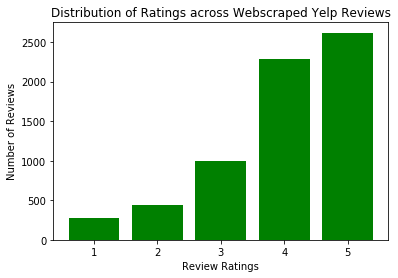

In [15]:
ratings_distribution = defaultdict(int) # Define an instance of a defaultdict into which the data will be populated
for rating in review_labels: # Loop over all ratings in the review labels, which the defaultdict will treat as int
    ratings_distribution[rating[1]] += 1 # Raise the count for that rating in the defaultdict based on the review
# Then visualize the distribution of review ratings using a barplot
plt.bar(ratings_distribution.keys(), ratings_distribution.values(), color='green')
plt.title('Distribution of Ratings across Webscraped Yelp Reviews')
plt.xlabel('Review Ratings')
plt.ylabel('Number of Reviews')

In [16]:
# check number of one start reviews
ratings_distribution[1]

280

In [21]:
review_features[0][2]

IndexError: list index out of range

In [30]:
# Reformat the processed tokenized reviews as a list of tuples after the processing has been completed
review_features = [(review,rating) for review,rating in review_features]

## Using the Review Features for a Simple Naive Bayes Classifier Model

In [31]:
# Shuffle the reviews and separate 70% into a training and 30% into test set
random.seed(32) # First pick a random seed stage value to randomize the shuffle
random.shuffle(review_features) # Then apply the random shuffling to the reviews
gap = round(len(review_features)*0.7)
training_set = review_features[:gap] # Separate into training set of reviews
test_set = review_features[gap:] # Separate into the test set of reviews
# Print the number of reviews in the training and test sets based on the split
print("Training Set: %d, Testing Set: %d" % (len(training_set), len(test_set)))

Training Set: 4630, Testing Set: 1984


In [32]:
# Initiate an instance of the nltk SentimentAnalyzer
sentiment = SentimentAnalyzer()

In [33]:
# Define a list of negation words using the mark_negation class of the nltk sentiment utility subpackage
all_words_neg = sentiment.all_words([nltk.sentiment.util.mark_negation(review[0], double_neg_flip = True) # <-,
                                     for review in training_set]) # Enables recognization of double negations/

In [34]:
# Define the feature extraction method for the nltk SentimerAnalyzer class
unigram_feats = sentiment.unigram_word_feats(words=all_words_neg, min_freq=4)
sentiment.add_feat_extractor(nltk.sentiment.util.extract_unigram_feats, unigrams=unigram_feats)

In [35]:
# Apply the feature extraction method defined above on the training and test sets
training_set_features = sentiment.apply_features(training_set)
test_set_features = sentiment.apply_features(test_set)

In [36]:
trainer = NaiveBayesClassifier.train # Define instance of the nltk Naive Bayes Classifier class
classifier = sentiment.train(trainer, training_set_features) # Train classifier on training set features
for key,value in sorted(sentiment.evaluate(test_set_features).items()): # Loop over results of the clasifier model
     print('{0}: {1}'.format(key, value)) # Evaluate the results of the Naive Bayes Classifier model

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.8039314516129032
F-measure [negative]: 0.5900948366701791
F-measure [positive]: 0.8711493872143095
Precision [negative]: 0.6320541760722348
Precision [positive]: 0.8533419857235561
Recall [negative]: 0.5533596837944664
Recall [positive]: 0.8897158322056834
